In [1]:
import netket as nk
import jax.numpy as jnp
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
from scipy.sparse.linalg import eigsh
import jax
from netket.operator.spin import sigmax,sigmaz
import jax.flatten_util
import pickle
from typing import Union, Any
import numpy as np
import jax
from jax import numpy as jnp
from flax import linen as nn
from jax.nn.initializers import normal
from netket.utils.types import NNInitFunc
from netket import nn as nknn
default_kernel_init = normal(stddev=0.01)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from tqdm import trange
import time
from sklearn.decomposition import PCA, KernelPCA

In [2]:
runs_dict = {'energies': {}, 'energies_exact': {}, 'energies_error': {}, 'infid': {}, 'hs': {}}

In [3]:

def get_psi(vstate,hi,model):
    '''
    Function that returns a vector with the wavefunction probability amplitudes

    Inputs ---
    vsate: Netket's vstate object, the variational quantum state
    hi:    Hilbert space 
    model: Instance of RBM model

    Outputs ---
    psi:   Vector of probability amplitudes indexed all possible by configurations/eigenstates of the Hilbert space

    '''
    parameters = vstate.variables
    all_configurations = hi.all_states()

    logpsi = model.apply(parameters,all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi/ jnp.linalg.norm(psi)

    return psi

    
def hidden_activations(params, v):
    """
    Compute the activations of the hidden units given the visible units using log(cosh).
    h_probs = log(cosh(v @ W + c))
    """
    W, c = params['Dense']['kernel'], params['Dense']['bias']
    pre_activation = v @ W + c  # Linear transformation
    h_probs = nk.nn.activation.log_cosh(pre_activation)  # Log-cosh activation
    return h_probs

def infidelity(wavefunc1, wavefunc2):

    norm = np.linalg.norm(wavefunc1)*np.linalg.norm(wavefunc2)
    overlap = np.dot(np.conjugate(wavefunc1), wavefunc2)
    fidelity = np.abs(overlap)**2/norm

    return 1 - fidelity

def get_weights(vstate):
    '''
    Function that returns flattened array containing the RBM weights

    Input:      Netket's vstate object, the variational quantum state. 
    Output:     Flattened 1D array with RBM weights
    '''

    rbm_params = vstate.parameters

    weights = rbm_params['Dense']['kernel']
    
    return jnp.ravel(weights)

In [4]:
all_hs = jnp.arange(0,3.0001,0.1)
all_hs, all_hs.shape

(Array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ], dtype=float64),
 (31,))

In [17]:
J = [0.3, 1]
L = 8

In [18]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])

# Define the netket graph object
g = nk.graph.Graph(edges=edge_colors)

In [19]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

In [20]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)

In [21]:
op = nk.operator.GraphOperator(hi, graph=g, bond_ops=bond_operator, bond_ops_colors=bond_color)

In [22]:
import netket.nn as nknn
import flax.linen as nn

import jax.numpy as jnp

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], 
                     use_bias=True, 
                     param_dtype=np.complex128, 
                     kernel_init=nn.initializers.normal(stddev=0.01), 
                     bias_init=nn.initializers.normal(stddev=0.01)
                    )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x
        
model = FFNN()

In [36]:
# We shall use an exchange Sampler which preserves the global magnetization (as this is a conserved quantity in the model)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, d_max = 2)

# Construct the variational state
vs = nk.vqs.FullSumState(hi, model)

# We choose a basic, albeit important, Optimizer: the Stochastic Gradient Descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.01)

# We can then specify a Variational Monte Carlo object, using the Hamiltonian, sampler and optimizers chosen.
# Note that we also specify the method to learn the parameters of the wave-function: here we choose the efficient
# Stochastic reconfiguration (Sr), here in an iterative setup
gs = nk.VMC(hamiltonian=op, optimizer=opt, variational_state=vs, preconditioner=sr)

In [37]:
# We need to specify the local operators as a matrix acting on a local Hilbert space 
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, j))*((-1)**(i-j))/L

In [38]:
# Run the optimization protocol
gs.run(out='test', n_iter=600, obs={'Structure Factor': structure_factor})

  0%|          | 0/600 [00:00<?, ?it/s]

/Users/vini/miniforge3/envs/nqsrl/lib/python3.12/site-packages/jax/_src/linear_util.py:193: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_generated/error

(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.03139853477478027
   	Params: 0.03493762016296387,)

In [39]:
# Load the data from the .log file
import json

data=json.load(open("test.log"))

iters = data['Energy']['iters']
energy=data['Energy']['Mean']['real']
sf=data['Structure Factor']['Mean']['real']

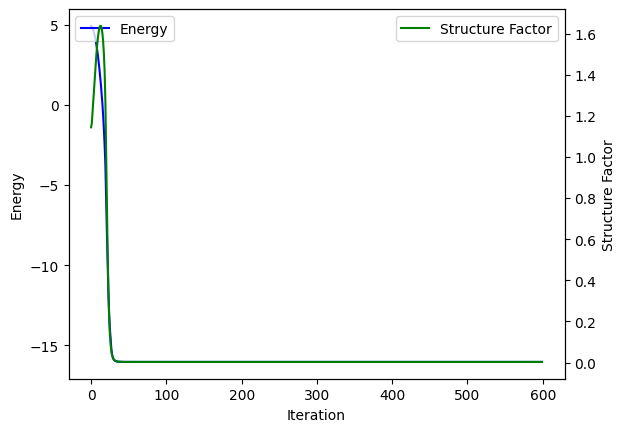

In [40]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(sf), color='green', label='Structure Factor')
ax2.set_ylabel('Structure Factor')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

In [44]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True, k = 1)
structure_factor_gs = (ket_gs.T.conj()@structure_factor.to_linear_operator()@ket_gs).real[0,0]



In [45]:
np.abs(np.abs(energy)[-1] - np.abs(E_gs))
np.abs(np.abs(sf)[-1] - np.abs(structure_factor_gs))


np.float64(2.584019539141058e-10)

In [469]:
activations_all_h = []
wavefuncs_all_h = []
params_all_h = []
exact_wavefuncs_all_h = []
wavefuncs_error_all_h = []  
infidelity_all_h = [] 
energies_all_h = []
energies_exact_all_h = []


for i, h_i in enumerate(all_hs)[::-1]:
    N = 8
    J = -1  
    g = nk.graph.Chain(length=N, pbc=False) 
    hilbert = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    hamiltonian = nk.operator.Ising(hilbert, h=h_i, graph=g)
    wv = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=True)
    exact_energy, exact_wavefunc = wv[0][0], wv[1].reshape(-1)
    if i == 0 or True:
        magnetizations = hilbert.all_states().sum(1)/N
        model = nk.models.RBM(alpha = 2)
        vstate = nk.vqs.FullSumState(hilbert, model)
    optimizer = nk.optimizer.Adam()
    variance = []
    energy = []
    number_of_runs = 2 #if i == 0 else 1
    for _ in range(number_of_runs):
        gs = nk.driver.VMC(hamiltonian,optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
        log = nk.logging.RuntimeLog()
        gs.run(n_iter=1000,out=log,show_progress=False)
        energy.extend(log['Energy']['Mean'])
        variance.extend(log['Energy']['Variance'])
    wavefunc = get_psi(vstate,hilbert,model)
    wavefuncs_error_all_h.append(np.abs(np.abs(wavefunc) - np.abs(exact_wavefunc)))
    infidelity_all_h.append(infidelity(wavefunc, exact_wavefunc))
    wavefuncs_all_h.append(wavefunc)
    exact_wavefuncs_all_h.append(exact_wavefunc)
    energies_all_h.append(np.array(energy))
    energies_exact_all_h.append(exact_energy)
    params_all_h.append(get_weights(vstate))

    activations = []

    for i in range(2**N):
        act = hidden_activations(vstate.parameters, hilbert.all_states()[i])
        activations.append(act.tolist())

    activations_all_h.append(activations)

    print('h: ', "{:.3f}".format(h_i), 
          ' | energy error: ', "{:.3e}".format((energy-exact_energy)[-1].item()),
          ' | avg wavefunc error: ', "{:.3e}".format(np.mean(wavefuncs_error_all_h[-1])), 
          ' | infidelity: ', "{:.3e}".format(np.mean(infidelity_all_h[-1])))


h:  3.000  | energy error:  1.274e-06  | avg wavefunc error:  1.378e-05  | infidelity:  8.201e-08
h:  2.975  | energy error:  3.478e-07  | avg wavefunc error:  7.292e-06  | infidelity:  2.129e-08
h:  2.950  | energy error:  4.796e-07  | avg wavefunc error:  7.894e-06  | infidelity:  2.469e-08
h:  2.925  | energy error:  3.433e-07  | avg wavefunc error:  6.824e-06  | infidelity:  1.822e-08
h:  2.900  | energy error:  6.215e-07  | avg wavefunc error:  1.148e-05  | infidelity:  5.535e-08
h:  2.875  | energy error:  1.096e-06  | avg wavefunc error:  1.410e-05  | infidelity:  7.595e-08
h:  2.850  | energy error:  5.710e-07  | avg wavefunc error:  9.698e-06  | infidelity:  3.846e-08
h:  2.825  | energy error:  3.793e-07  | avg wavefunc error:  7.925e-06  | infidelity:  2.545e-08
h:  2.800  | energy error:  8.115e-07  | avg wavefunc error:  1.205e-05  | infidelity:  5.801e-08
h:  2.775  | energy error:  2.225e-07  | avg wavefunc error:  4.918e-06  | infidelity:  1.004e-08
h:  2.750  | energy 

In [352]:
energies_all_h = np.array(energies_all_h)
energies_exact_all_h = np.array(energies_exact_all_h)
energies_error_all_h = np.zeros_like(energies_all_h)
for i in range(len(energies_all_h)):
    energies_error_all_h[i] = np.abs(np.abs(energies_all_h[i]) - np.abs(energies_exact_all_h[i]))

In [353]:
version = 'v4'
runs_dict['energies'][version] = energies_all_h
runs_dict['energies_exact'][version] = energies_exact_all_h
runs_dict['energies_error'][version] = energies_error_all_h
runs_dict['infid'][version] = infidelity_all_h
runs_dict['hs'][version] = all_hs

In [479]:
color_h = []
for i in range(40):
    color_h.append(plt.cm.RdBu_r(i/40/2))
for i in range(81):
    color_h.append(plt.cm.RdBu_r(0.5+(i/81/2)))
color_h = color_h[::-1]

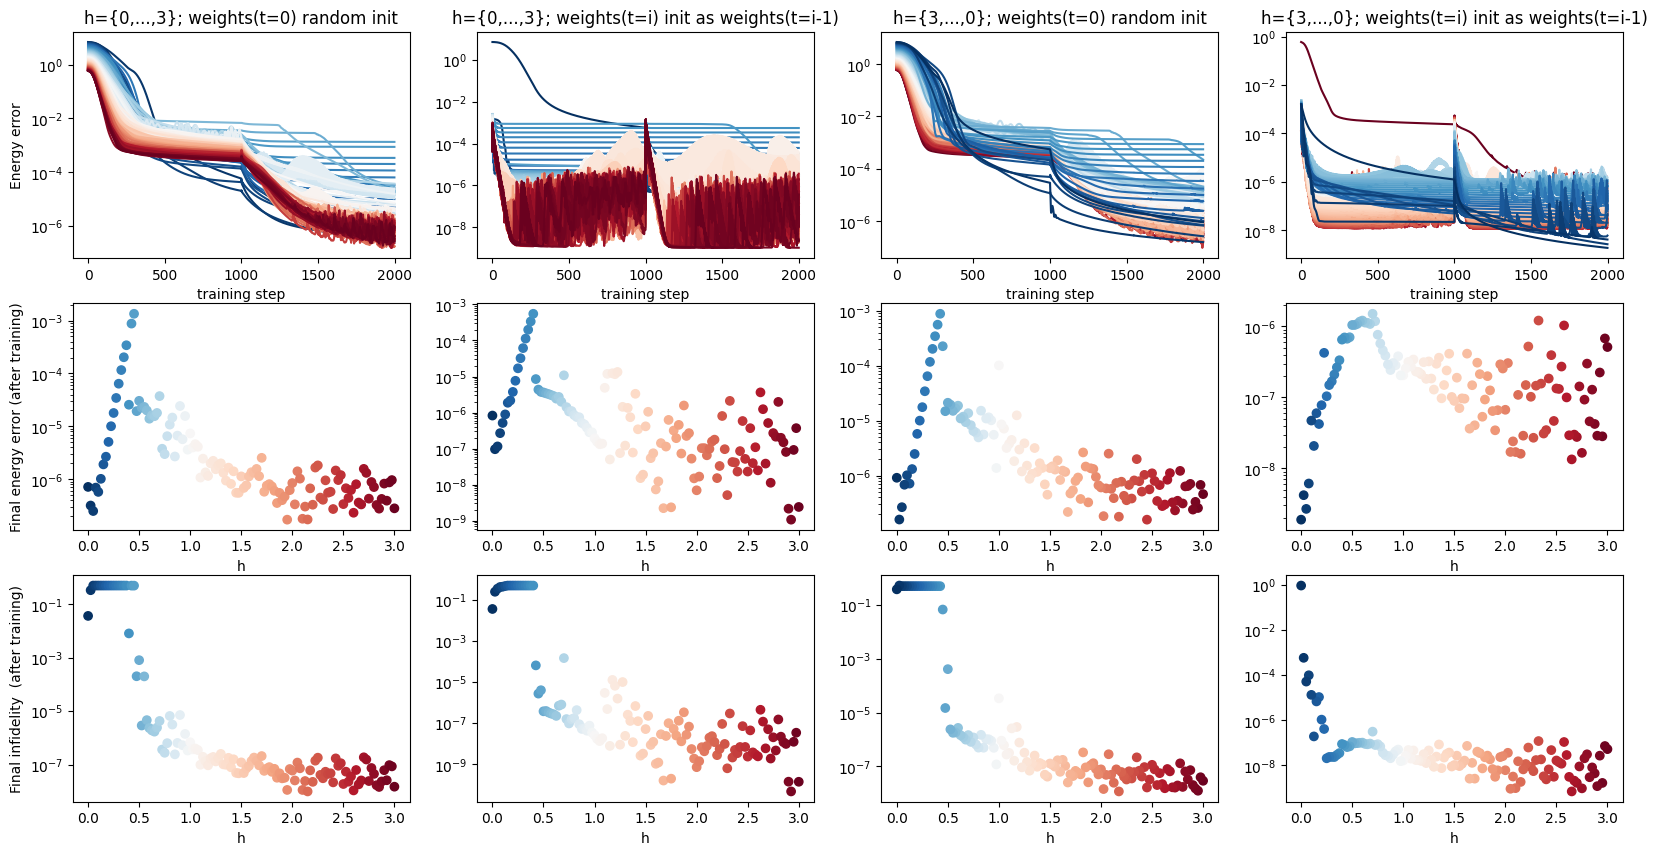

In [498]:
# v1: from init: energies vs steps (Color is h) | energy_final vs h | infid_final vs h
# v2: previous w: energies vs steps | energy_Final vs h | infid_final vs h

# v3: from init: energies vs steps (Color is h) | energy_final vs h | infid_final vs h
# v4: previous w: energies vs steps | energy_Final vs h | infid_final vs h
fig, ax = plt.subplots(3,4, figsize = (20,10))
for version in (1,2):
    for i in range(len(energies_error_all_h)):
        ax[0,version-1].plot(runs_dict['energies_error'][f'v{version}'][i], color = color_h[::-1][i])
    ax[1,version-1].scatter(runs_dict['hs'][f'v{version}'], np.array(runs_dict['energies_error'][f'v{version}'][:,-1]), color = color_h[::-1])
    ax[2,version-1].scatter(runs_dict['hs'][f'v{version}'], np.array(runs_dict['infid'][f'v{version}']), color = color_h[::-1])
    for i in range(3):
        ax[i,version-1].set_yscale('log')
for version in (3,4):
    for i in range(len(energies_error_all_h)):
        ax[0,version-1].plot(runs_dict['energies_error'][f'v{version}'][i], color = color_h[i])
    ax[1,version-1].scatter(runs_dict['hs'][f'v{version}'], np.array(runs_dict['energies_error'][f'v{version}'][:,-1]), color = color_h)
    ax[2,version-1].scatter(runs_dict['hs'][f'v{version}'], np.array(runs_dict['infid'][f'v{version}']), color = color_h)
    for i in range(3):
        ax[i,version-1].set_yscale('log')


ax[0,0].set_title('h={0,...,3}; weights(t=0) random init')
ax[0,1].set_title('h={0,...,3}; weights(t=i) init as weights(t=i-1)')
ax[0,2].set_title('h={3,...,0}; weights(t=0) random init')
ax[0,3].set_title('h={3,...,0}; weights(t=i) init as weights(t=i-1)')

ax[0,0].set_ylabel('Energy error')
ax[1,0].set_ylabel('Final energy error (after training)')
ax[2,0].set_ylabel('Final infidelity  (after training)')

for i in range(4):
    ax[0,i].set_xlabel('training step')
    ax[1,i].set_xlabel('h')
    ax[2,i].set_xlabel('h')

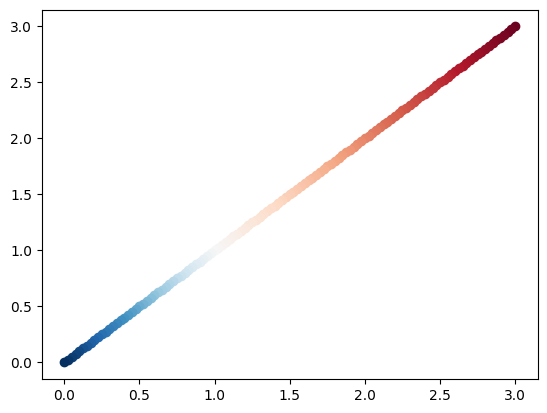

In [481]:
for i in range(len(all_hs)):
    plt.scatter(all_hs[i], all_hs[i], color = color_h[i])

In [482]:
energies_exact_all_h[i]

np.float64(-7.000000000000004)

In [483]:
energies = np.array(energies_all_h)
energies[:,-1]

array([-24.58627445, -24.391253  , -24.1963162 , -24.00146762,
       -23.8067089 , -23.61204267, -23.41747262, -23.22300001,
       -23.02862722, -22.83435869, -22.64019571, -22.44614163,
       -22.25219979, -22.05837363, -21.86466619, -21.67108109,
       -21.47762197, -21.28429237, -21.09109635, -20.89803806,
       -20.70512175, -20.51235198, -20.31973303, -20.12727004,
       -19.9349673 , -19.74283168, -19.55086712, -19.35907985,
       -19.16747601, -18.97606104, -18.78484356, -18.59382863,
       -18.40302325, -18.21243661, -18.02207491, -17.83194748,
       -17.64206244, -17.45242969, -17.26305861, -17.0739573 ,
       -16.88514106, -16.69661505, -16.508398  , -16.32049822,
       -16.13292898, -15.94570393, -15.75884017, -15.57235103,
       -15.38625558, -15.20056985, -15.01531179, -14.83050275,
       -14.64616358, -14.46231634, -14.27898545, -14.09619497,
       -13.91397413, -13.7323539 , -13.55136128, -13.37103339,
       -13.19140214, -13.01251267, -12.8344023 , -12.65

In [484]:
acts_h = jnp.array(activations_all_h).reshape(len(activations_all_h), -1)

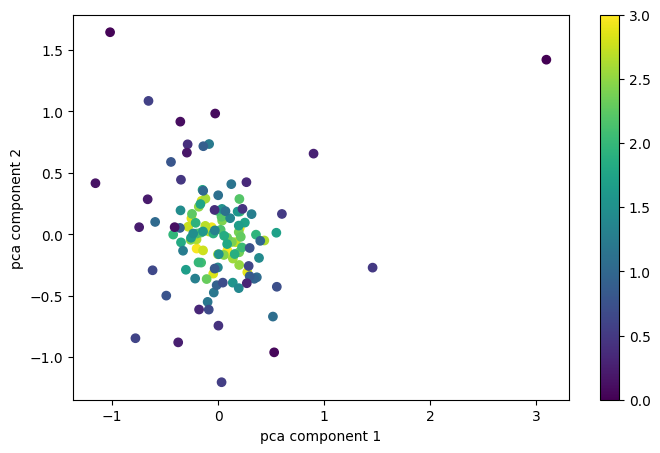

In [491]:
pca = KernelPCA(n_components = 3, kernel = 'linear', degree = 11)
X = pca.fit_transform(params_all_h)
plt.figure(figsize = (8,5))
scatter = plt.scatter(X[:, 0], X[:, 1], c=all_hs)
plt.colorbar(scatter)
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.show()

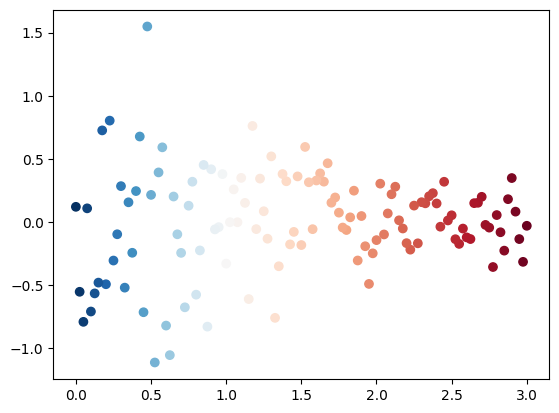

In [497]:
plt.scatter(all_hs, X[:,2], c=color_h, label = 'pca1')


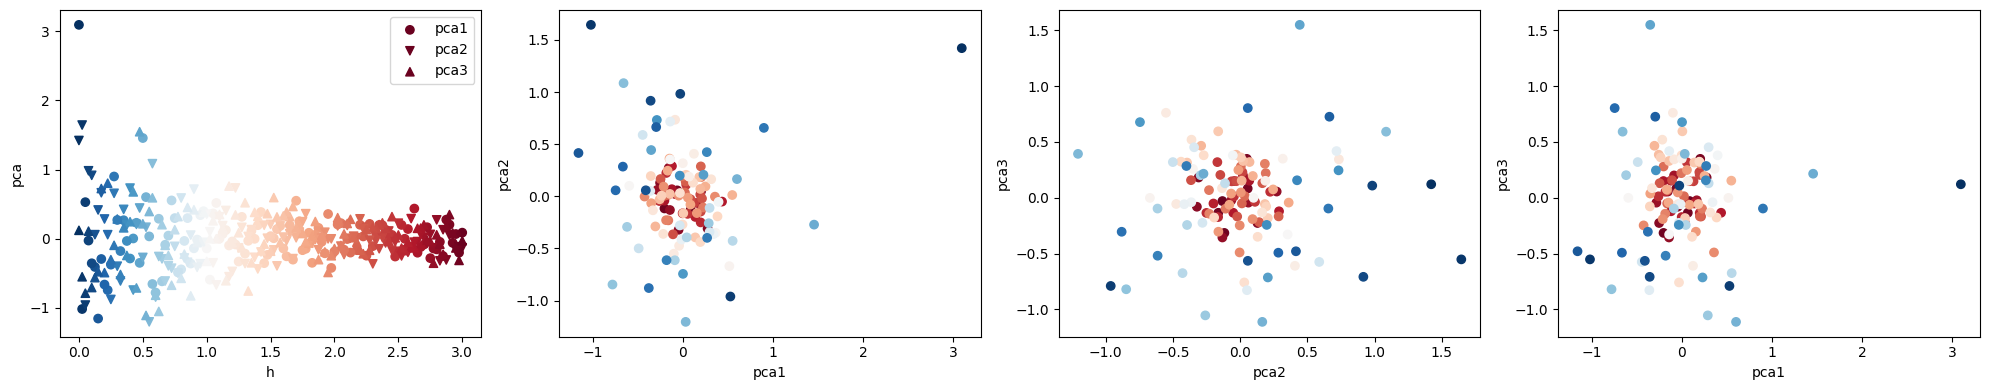

In [492]:
fig, ax = plt.subplots(1,4, figsize = (20,4))
ax[0].scatter(all_hs, X[:,0], c=color_h, label = 'pca1')
ax[0].scatter(all_hs, X[:,1], c=color_h, marker = 'v', label = 'pca2')
ax[0].scatter(all_hs, X[:,2], c=color_h, marker = '^', label = 'pca3')
ax[0].legend()
ax[0].set_xlabel('h')
ax[0].set_ylabel('pca')
ax[1].scatter(X[:, 0], X[:, 1], c=color_h)
ax[1].set_xlabel('pca1')
ax[1].set_ylabel('pca2')
ax[2].scatter(X[:, 1], X[:, 2], c=color_h)
ax[2].set_xlabel('pca2')
ax[2].set_ylabel('pca3')
ax[3].scatter(X[:, 0], X[:, 2], c=color_h)
ax[3].set_xlabel('pca1')
ax[3].set_ylabel('pca3')
plt.tight_layout()
plt.show()

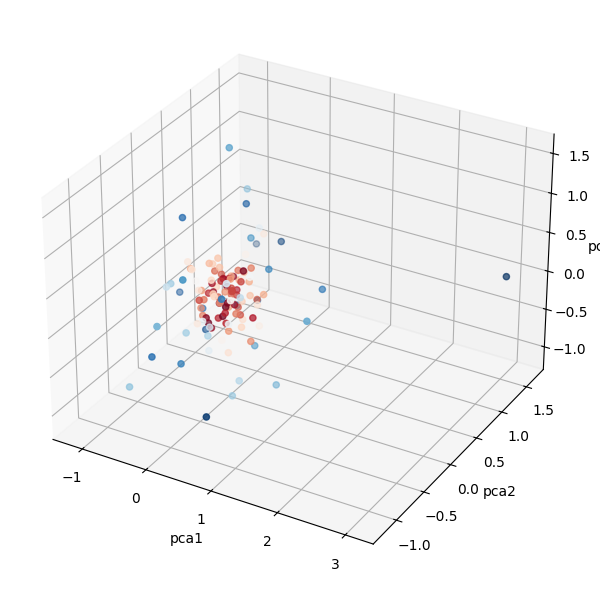

In [493]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color_h, marker='o')
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.tight_layout()
plt.show()

In [413]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(color_h)

In [390]:
all_hs

Array([3.   , 2.975, 2.95 , 2.925, 2.9  , 2.875, 2.85 , 2.825, 2.8  ,
       2.775, 2.75 , 2.725, 2.7  , 2.675, 2.65 , 2.625, 2.6  , 2.575,
       2.55 , 2.525, 2.5  , 2.475, 2.45 , 2.425, 2.4  , 2.375, 2.35 ,
       2.325, 2.3  , 2.275, 2.25 , 2.225, 2.2  , 2.175, 2.15 , 2.125,
       2.1  , 2.075, 2.05 , 2.025, 2.   , 1.975, 1.95 , 1.925, 1.9  ,
       1.875, 1.85 , 1.825, 1.8  , 1.775, 1.75 , 1.725, 1.7  , 1.675,
       1.65 , 1.625, 1.6  , 1.575, 1.55 , 1.525, 1.5  , 1.475, 1.45 ,
       1.425, 1.4  , 1.375, 1.35 , 1.325, 1.3  , 1.275, 1.25 , 1.225,
       1.2  , 1.175, 1.15 , 1.125, 1.1  , 1.075, 1.05 , 1.025, 1.   ,
       0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825, 0.8  , 0.775,
       0.75 , 0.725, 0.7  , 0.675, 0.65 , 0.625, 0.6  , 0.575, 0.55 ,
       0.525, 0.5  , 0.475, 0.45 , 0.425, 0.4  , 0.375, 0.35 , 0.325,
       0.3  , 0.275, 0.25 , 0.225, 0.2  , 0.175, 0.15 , 0.125, 0.1  ,
       0.075, 0.05 , 0.025, 0.   ], dtype=float64)

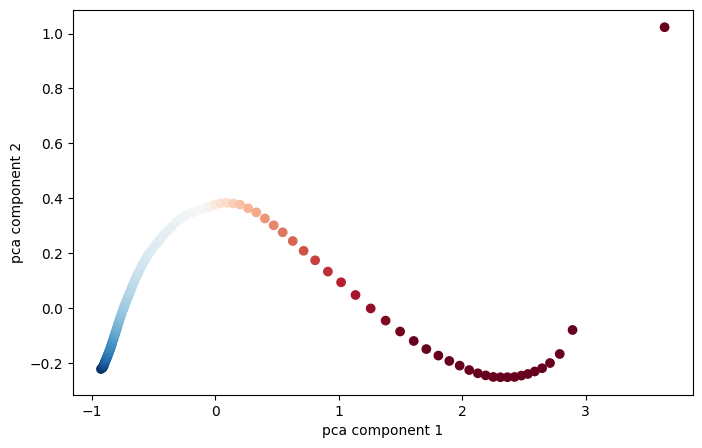

In [379]:
plt.figure(figsize = (8,5))
scatter = plt.scatter(X[:, 0], X[:, 2], c=color_h)
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.show()

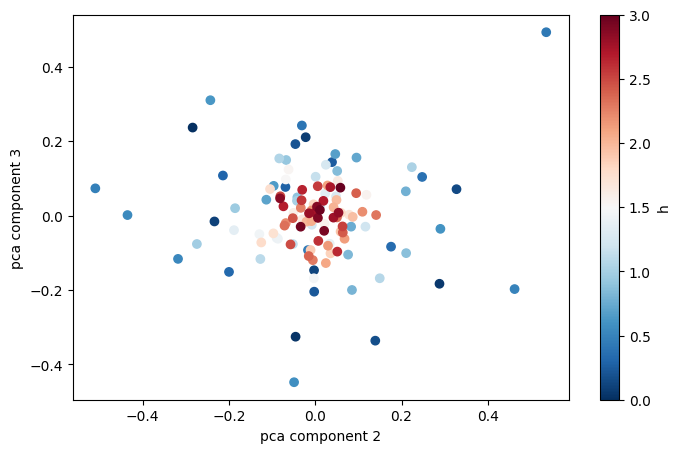

In [231]:
plt.figure(figsize = (8,5))
scatter = plt.scatter(X[:, 1], X[:, 2], c=all_hs, cmap='RdBu_r')
plt.colorbar(scatter, label='h')  
plt.xlabel('pca component 2')
plt.ylabel('pca component 3')
plt.show()